# CLV (Customer Lifetime Value) and RFM (Recency, Frequency, Monetary), and Clustering (Client Segmentation)

**RFM** is a customer segmentation technique based on purchasing behavior, and it consists of three key metrics:
- Recency: How long it has been since the customer's last purchase.
- Frequency: How often the customer makes a purchase.
- Monetary: How much money the customer has spent in total.
These metrics help evaluate the **value and engagement level** of each customer.

**CLV** (Customer Lifetime Value) estimates the **total economic value** a customer is expected to bring to the company over the course of their relationship. It typically takes into account:
- The average spending per purchase.
- Purchase frequency.
- Expected retention time.

Both of these techniques are highly valuable from a **business perspective**, as they provide quick and actionable insights that allow companies to perform **strategic segmentation, personalized marketing, churn prediction**, and more.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

### 1. Data

In [2]:
# load data tables: customers, orders, items, and product information
customers_df = pd.read_csv('data/olist_customers_dataset.csv')
# order and product relationship, with price, seller, shipping, etc.
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
products_df = pd.read_csv('data/olist_products_dataset.csv')

In [3]:
# merge dataframes to create a single dataframe with all relevant information
orders_customers_df = pd.merge(orders_df, customers_df, on='customer_id', how='left')

# here we are at a product level
df = pd.merge(order_items_df, orders_customers_df, on='order_id', how='left')
df = pd.merge(df, products_df, on='product_id', how='left')

# translate product category names to English
translation_df = pd.read_csv('data/product_category_name_translation.csv')
translation_dict = dict(zip(translation_df["product_category_name"], translation_df["product_category_name_english"]))
df["product_category_name"] = df["product_category_name"].replace(translation_dict)

# edit important date columns to have datetime format and date only
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
# df["order_purchase"] = pd.to_datetime(df["order_purchase_timestamp"]).dt.date
df["order_purchase"] = pd.to_datetime(df["order_purchase_timestamp"]).dt.date

### 2. RFM

In [4]:
# create a dataframe with the relevant columns for RFM analysis
df_rfm = df.groupby("customer_unique_id").agg(
    first_purchase_day = ('order_purchase_timestamp', 'min'),
    last_purchase_day = ('order_purchase_timestamp', 'max'),
    total_orders = ('order_id', 'nunique'),
    total_items = ('order_item_id', 'count'),
    total_price = ('price', 'sum'),
    average_price = ('price', 'mean'),
).reset_index()

# defining court date and the first date with values, to calculate frequency
court_date = df['order_purchase_timestamp'].max()
first_date = df['order_purchase_timestamp'].min()

# calculate the number of months between the first purchase and the court date
df_rfm["num_data_months"] = (court_date - first_date).days / 30

# calculate recency, frequency, and monetary values
df_rfm["Recency"] = (court_date - df_rfm["last_purchase_day"]).dt.days / 30
df_rfm["Frequency"] = df_rfm["total_orders"]
df_rfm["Frequency_per_month"] = df_rfm["total_orders"] / df_rfm["num_data_months"]
df_rfm["Monetary"] = df_rfm["total_price"]

df_rfm[["Recency", "Frequency", "Frequency_per_month", "Monetary"]].head()

,Recency,Frequency,Frequency_per_month,Monetary
0,3.833333,1,0.041209,129.90
1,3.933333,1,0.041209,18.90
2,18.033333,1,0.041209,69.00
3,10.833333,1,0.041209,25.99
4,9.733333,1,0.041209,180.00


### 3. CLV

CLV is a forward-looking metric that estimates the total revenue a business can expect from a customer over the duration of their relationship.
The basic formula is: *CLV = Average Purchase Value × Purchase Frequency × Customer Lifespan*

One of the challenges in calculating CLV is estimating the Customer Lifespan, since we often don't know exactly when a customer will stop purchasing. In this case, we will calculate in the following way:
*Customer Lifespan = 1 / (1 - Retention Rate)*. 
For example, if 80% of customers are retained year-over-year, the retention rate is 0.8.

In [5]:
# months to consider a customer as churned to calculate retention rate
churn_window = 12 # months

# column defining if a customer is churned or not
df_rfm['Churned'] = (df_rfm['Recency'] > churn_window).astype(int)

# customer lifespan calculation
retention_rate = (1-df_rfm['Churned'].mean())
print(f"Retention Rate: {retention_rate*100:.1f}%")
customer_lifespan = 1 / (1 - retention_rate)

# CLV calculation
df_rfm["CLV"] = df_rfm["average_price"] * df_rfm["Frequency"] * customer_lifespan

df_rfm[["customer_unique_id", "Recency", "Frequency", "Frequency_per_month", "Monetary", "CLV"]].sort_values(by="CLV", ascending=False)

Retention Rate: 76.3%


,customer_unique_id,Recency,Frequency,Frequency_per_month,Monetary,CLV
81388,da122df9eeddfedc1dc1f5349a1a690c,17.300000,2,0.082418,7388.00,31199.953972
82230,dc4802a71eae9be1dd28f5d788ceb526,18.900000,1,0.041209,6735.00,28442.296968
26015,459bef486812aa25204be022145caa62,1.300000,1,0.041209,6729.00,28416.958619
95131,ff4159b92c40ebe40454e3e6a7c35ed6,15.533333,1,0.041209,6499.00,27445.655233
89056,eebb5dda148d3893cdaf5b5ca3040ccb,16.733333,1,0.041209,4690.00,19806.142952
...,...,...,...,...,...,...
70557,bd06ce0e06ad77a7f681f1a4960a3cc6,11.800000,1,0.041209,2.29,9.670803
18518,317cfc692e3f86c45c95697c61c853a6,0.266667,1,0.041209,2.20,9.290728
25885,4546caea018ad8c692964e3382debd19,13.766667,1,0.041209,31.80,6.394917
80635,d80730c15c647bc8f2ad77c908ba5ca9,4.366667,1,0.041209,0.85,3.589599


Here we can identify our **top and bottom customers** in terms of Customer Lifetime Value (CLV). Based on both CLV and RFM metrics, we can define **top-of-funnel and bottom-of-funnel** client groups.

However, to gain deeper insights, it would be highly valuable to go a step further and perform a **customer segmentation**. This would allow us to assign meaningful labels to the different types of customers we have, better understand their behaviors, and design more targeted business strategies.

### 4. Clustering (Client Segmentation)

#### 4.1. Model

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

scaler = StandardScaler()

# define the columns to be used for clustering
clustering_columns = ["Recency", "Frequency", "Monetary", "CLV"]

# scale data
X = scaler.fit_transform(df_rfm[clustering_columns])

# model creation and prediction
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)

# labeling the customers with the cluster labels
df_rfm["segment"] = kmeans.labels_

# printing the silhouette score
score = silhouette_score(X, labels)
print("Silhouette score: ", score)


/Users/josep/Documents/MetyisProgrammingChallenge/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette score:  0.7210314864857508


We initially assumed 3 clusters to evaluate the baseline performance, but it's very useful to test different clustering scores (based on various calculations and objectives) across a range of cluster numbers, and then decide the optimal number of clusters based on the results and insights obtained.

#### 4.2. Model optimization

Here are the three metrics we will use to evaluate the segmentation.

- **Silhouette**: Measures how similar each point is to its own cluster vs. other clusters. Range: [-1, 1], where higher is better.
- **Davies-Bouldin Index** (DBI): Measures intra-cluster similarity vs. inter-cluster differences. Lower = better. < 0.6 is typically considered good
- **Calinski-Harabasz Index** (Variance Ratio Criterion) Ratio of between-cluster dispersion to within-cluster dispersion. Higher = better.


In [7]:
# calculate number of clusters
scores_silhouette = []
scores_davies = []
scores_calinski = []

# number of clusters to iterate
num_clusters = range(2, 11)

# iterating the model with different number of clusters and saving the results
for k in tqdm(num_clusters):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score_silhouette = silhouette_score(X, labels)
    scores_silhouette.append(score_silhouette)
    score_davies = davies_bouldin_score(X, labels) 
    scores_davies.append(score_davies)
    score_calinski = calinski_harabasz_score(X, labels) 
    scores_calinski.append(score_calinski)
    


  0%|          | 0/9 [00:00<?, ?it/s]/Users/josep/Documents/MetyisProgrammingChallenge/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 11%|█         | 1/9 [02:24<19:12, 144.00s/it]/Users/josep/Documents/MetyisProgrammingChallenge/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 22%|██▏       | 2/9 [04:46<16:40, 142.88s/it]/Users/josep/Documents/MetyisProgrammingChallenge/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly

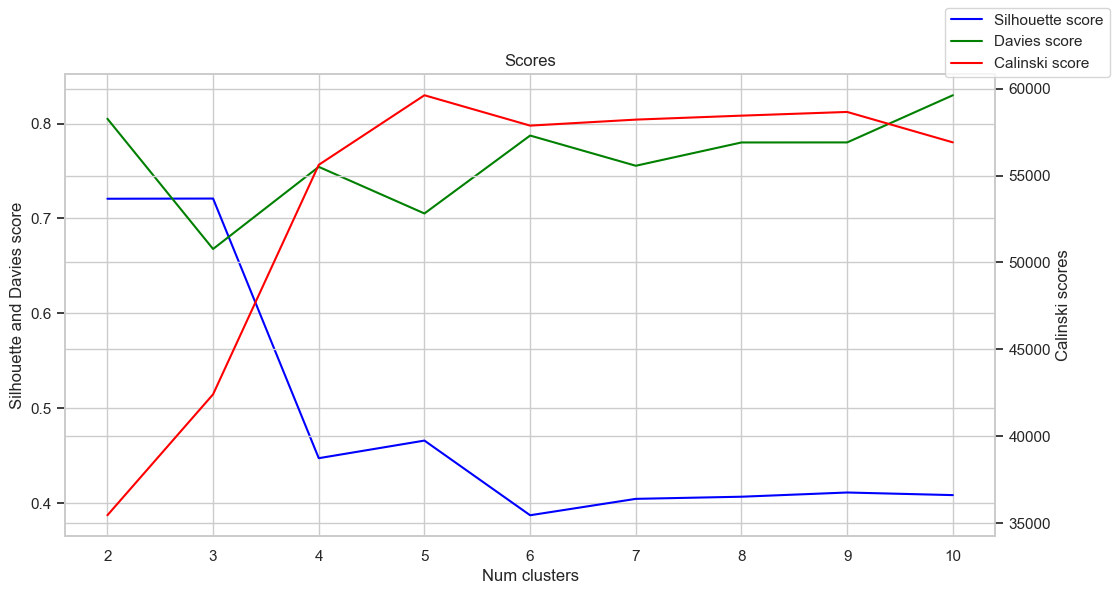

In [13]:
# plot results of the number of clusters optimization with the scores
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(num_clusters, scores_silhouette, color='blue', label='Silhouette score')
ax1.plot(num_clusters, scores_davies, color='green', label='Davies score')
ax1.set_ylabel('Silhouette and Davies score')

ax2 = ax1.twinx()

ax2.plot(num_clusters, scores_calinski, color='red', label='Calinski score')
ax2.set_ylabel('Calinski scores')

fig.legend()
ax1.set_title('Scores')
ax1.set_xlabel('Num clusters')

plt.show()

As we can see, the initial baseline of 3 clusters performs quite well, achieving the best scores using both the Davies-Bouldin and Silhouette methods. However, the Calinski-Harabasz score is very low, and 3 clusters seem too few to create a meaningful and detailed customer segmentation.

For this reason, we decided to go with **5 clusters**, as this configuration achieves the highest Calinski score, the second-best Davies score, and the third-best Silhouette score.

In [14]:
# creating again the clustering model with 5 clusters
# defining scaler
scaler = StandardScaler()

# define the columns to be used for clustering
clustering_columns = ["Recency", "Frequency", "Monetary", "CLV"]

# scale data
X = scaler.fit_transform(df_rfm[clustering_columns])

# model creation and prediction
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

# labeling the customers with the cluster labels
df_rfm["segment"] = kmeans.labels_

/Users/josep/Documents/MetyisProgrammingChallenge/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [16]:
# segment descriptive labels based on observed RFM and CLV
segment_map = {
    0: "Lost client / Churned", # compró hace tiempo, no frecuente y poco dinero
    1: "Sporadical big customer", # Potential spenders, # not frequent but more value # comprador poco habitual pero con gran gasto de dinero y el mayor en life time value, muy propensos a hacer campañas comerciales (black friday cuadra con meses de recency)   
    2: "New customer", # low recency, frequency and monetary, muy pronto para sacar conclusiones
    3: "Frequent low value", # frequent but low value and CLV
    4: "Sporadical mid customer" # sporadical recency, small frequency 
}

# map labels
df_rfm['segment_label'] = df_rfm['segment'].map(segment_map)

# dataframe with segments and average values of RFM and CLV per segment
grouped = df_rfm.groupby(["segment","segment_label"])[clustering_columns].mean().round(2)
grouped['Size'] = df_rfm.groupby(["segment","segment_label"]).size()

display(grouped)




,,Recency,Frequency,Monetary,CLV,Size
segment,segment_label,,,,,
0,Lost client / Churned,13.11,1.00,100.55,389.44,36899
1,Sporadical big customer,8.29,1.05,1785.88,7004.27,716
2,New customer,4.41,1.00,99.34,384.41,49829
3,Frequent low value,7.51,2.11,241.01,869.38,2876
4,Sporadical mid customer,7.94,1.00,580.27,2233.37,5100


With these results, we can draw the following conclusions:

- **Segment 0**: This is the largest group but also the least valuable (if we don't consider the new customers). It is ideal for reactivation campaigns or to analyze the causes of churn.

- **Segment 1**: These are high-value customers who could become premium clients if better activated.

- **Segment 2**: Many recent customers with low engagement so far.

- **Segment 3**: They purchase frequently but with a low average ticket. They are good customers who could generate more value if offered upselling or cross-selling opportunities.

- **Segment 4**: They purchase occasionally with a mid-range value. They could migrate to higher-value segments if encouraged with offers, personalized recommendations, or retention campaigns.

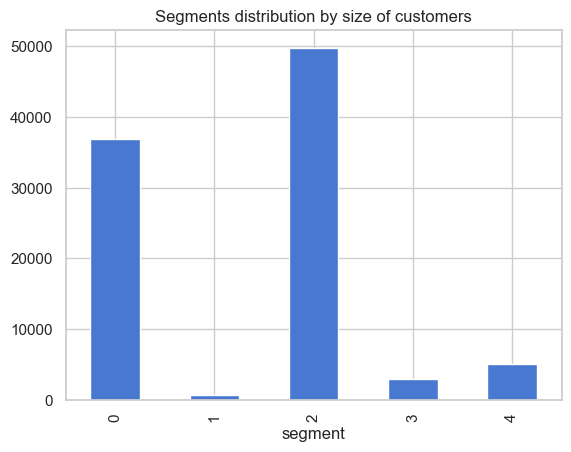

In [17]:
# segments distribution by size of customers
df_rfm["segment"].value_counts().sort_index().plot(kind='bar')
plt.title("Segments distribution by size of customers")
plt.show()

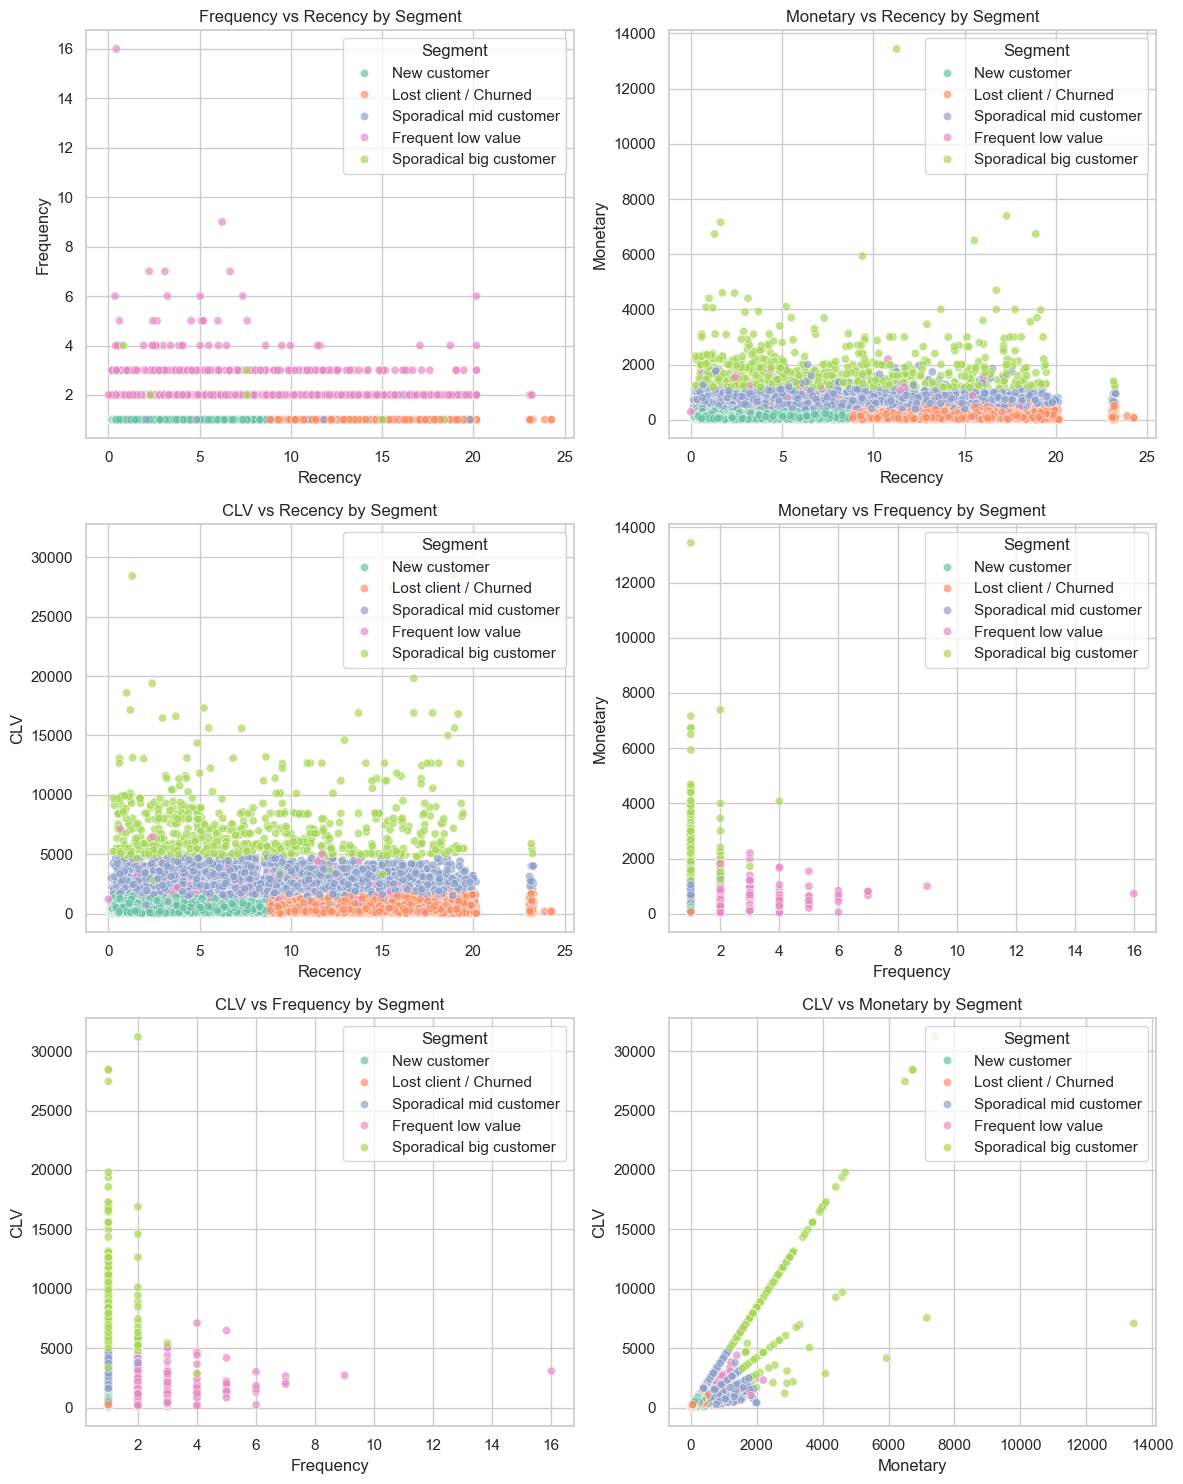

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Lista de features
features = ['Recency', 'Frequency', 'Monetary', 'CLV']
feature_pairs = list(combinations(features, 2))

# Configuración de estilo
sns.set(style="whitegrid", palette="muted")

# Número de plots
n_plots = len(feature_pairs)

# Crear figura con subplots (2 columnas, filas según sea necesario)
cols = 2
rows = (n_plots + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 5*rows))
axes = axes.flatten()  # para indexar fácilmente

for i, (x_feat, y_feat) in enumerate(feature_pairs):
    ax = axes[i]
    sns.scatterplot(data=df_rfm[["Recency", "Frequency", "Monetary", "CLV", "segment_label"]], x=x_feat, y=y_feat, hue='segment_label', palette='Set2', alpha=0.7, ax=ax)
    ax.set_title(f'{y_feat} vs {x_feat} by Segment')
    ax.legend(title='Segment', loc='upper right')

# Eliminar subplots vacíos si existen
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Performing customer clustering has provided significant value from both a business and strategic perspective. By grouping customers based on their purchasing behavior (using Recency, Frequency, Monetary, and CLV), we’ve gained a much deeper understanding of the different types of customers that interact with the business.

This segmentation allows us to:

- **Understand customer behavior more clearly**, identifying which segments are high-value, which are at risk of churning, and which have potential for growth.

- **Tailor marketing strategies to each segment**.

- **Support churn prediction models** by using these clusters as features